# Transfer Learning on ResNet-50 and Inception-v3

## Import

In [0]:
import os
os.environ['CUDA_LAUNCH_BLOCKING']="1"
import time
import torch
import pandas as pd
import numpy as np
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets
from torchvision import transforms
import matplotlib.pyplot as plt
from PIL import Image
%matplotlib inline
from torchvision import models

if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True

In [5]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Settings

In [0]:
##########################
### SETTINGS
##########################

# Device
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Hyperparametersf
RANDOM_SEED = 479
LEARNING_RATE = 0.1
NUM_EPOCHS = 20
BATCH_SIZE = 256

# Architecture
NUM_CLASSES = 45

## Custom Dataset Class

In [0]:
class MyDataset_RGB(Dataset):

    def __init__(self, csv_path, img_dir, transform=None):
    
        df = pd.read_csv(csv_path)
        self.img_dir = img_dir
        self.img_names = df['File Name']
        self.y = df['Class Label']
        self.transform = transform

    def __getitem__(self, index):
        img = Image.open(os.path.join(self.img_dir,
                                      self.img_names[index]))
        
        # make 1 color channel to 3 
        ary = np.array(img)
        if len(ary.shape) < 3:
          ary = np.stack((ary,)*3,axis=-1)
          img = Image.fromarray(ary, 'RGB')
                    
        if self.transform is not None:
            img = self.transform(img)
        
        label = self.y[index]
        return img, label

    def __len__(self):
        return self.y.shape[0]

## Data Augmentation 

In [0]:
# For ResNet-50
train_transforms_resnet = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225))
])

valid_transforms_resnet = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225))
])

test_transforms_resnet = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225))
])

In [0]:
# For Inception-v3
train_transforms_incept = transforms.Compose([
    transforms.Resize(size=(299, 299)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225))
])

valid_transforms_incept = transforms.Compose([
    transforms.Resize(size=(299, 299)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225))
])

test_transforms_incept = transforms.Compose([
    transforms.Resize(size=(299, 299)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225))
])

## Custom Data Loader

In [0]:
# For ResNet-50
train_dataset_resnet = MyDataset_RGB(csv_path='/content/drive/My Drive/STAT 479 Project/TrainingCorrect_combinedULcases.csv',
                          img_dir='/content/drive/My Drive/STAT 479 Project/RenamedData',
                          transform=train_transforms_resnet)
train_loader_resnet = DataLoader(dataset=train_dataset_resnet,
                          batch_size=256,
                          shuffle=True, # want to shuffle the dataset
                          num_workers=4) # number processes/CPUs to use

valid_dataset_resnet = MyDataset_RGB(csv_path='/content/drive/My Drive/STAT 479 Project/ValidationCorrect_combinedULcases.csv',
                          img_dir='/content/drive/My Drive/STAT 479 Project/RenamedData',
                          transform=valid_transforms_resnet)
valid_loader_resnet = DataLoader(dataset=valid_dataset_resnet,
                          batch_size=256,
                          shuffle=False, 
                          num_workers=4) # number processes/CPUs to use

test_dataset_resnet = MyDataset_RGB(csv_path='/content/drive/My Drive/STAT 479 Project/TestingCorrect_combinedULcases.csv',
                          img_dir='/content/drive/My Drive/STAT 479 Project/RenamedData',
                          transform=test_transforms_resnet)
test_loader_resnet = DataLoader(dataset=test_dataset_resnet,
                          batch_size=256,
                          shuffle=False, 
                          num_workers=4) # number processes/CPUs to use


In [0]:
# For Inception-v3
train_dataset_incept = MyDataset_RGB(csv_path='/content/drive/My Drive/STAT 479 Project/TrainingCorrect_combinedULcases.csv',
                          img_dir='/content/drive/My Drive/STAT 479 Project/RenamedData',
                          transform=train_transforms_incept)
train_loader_incept = DataLoader(dataset=train_dataset_incept,
                          batch_size=256,
                          shuffle=True, # want to shuffle the dataset
                          num_workers=4) # number processes/CPUs to use

valid_dataset_incept = MyDataset_RGB(csv_path='/content/drive/My Drive/STAT 479 Project/ValidationCorrect_combinedULcases.csv',
                          img_dir='/content/drive/My Drive/STAT 479 Project/RenamedData',
                          transform=valid_transforms_incept)
valid_loader_incept = DataLoader(dataset=valid_dataset_incept,
                          batch_size=256,
                          shuffle=False, 
                          num_workers=4) # number processes/CPUs to use

test_dataset_incept = MyDataset_RGB(csv_path='/content/drive/My Drive/STAT 479 Project/TestingCorrect_combinedULcases.csv',
                          img_dir='/content/drive/My Drive/STAT 479 Project/RenamedData',
                          transform=test_transforms_incept)
test_loader_incept = DataLoader(dataset=test_dataset_incept,
                          batch_size=256,
                          shuffle=False, 
                          num_workers=4) # number processes/CPUs to use


## Transfer Learning on Convolution Neural Network

## Settings

In [0]:
def compute_epoch_loss_CNN(model, data_loader, pretrained):
    curr_loss, num_examples = 0., 0
    with torch.no_grad():
        for features, targets in data_loader:
            features = features.to(DEVICE)
            targets = targets.to(DEVICE)
            if pretrained == "Resnet":
                logits = model(features)
                probas = F.softmax(logits, dim=1)
            elif pretrained == "Inception":
                logits = model(features)
            else:
                logits, probas = model(features)
            loss = F.cross_entropy(logits, targets, reduction='sum')
            num_examples += targets.size(0)
            curr_loss += loss

        curr_loss = curr_loss / num_examples
        return curr_loss


def compute_accuracy_CNN(model, data_loader, pretrained, detail):
    correct_pred, num_examples = 0, 0
    labels, predictions, result = [], [], []
    
    with torch.no_grad():
        for i, (features, targets) in enumerate(data_loader):
            
            features = features.to(DEVICE)
            targets = targets.to(DEVICE)

            if pretrained == "Resnet":
                logits = model(features)
                probas = F.softmax(logits, dim=1)
                _, predicted_labels = torch.max(probas, 1)
            elif pretrained == "Inception":
                outputs = model(features)
                _, predicted_labels = torch.max(outputs, 1)
            else:
                logits, probas = model(features)
                _, predicted_labels = torch.max(probas, 1)
            
            num_examples += targets.size(0)
            correct_pred += (predicted_labels == targets).sum()
            if detail:
                targets = targets.cpu().numpy()
                predicted_labels = predicted_labels.cpu().numpy()
                labels = np.concatenate((labels, targets), axis=0)
                predictions = np.concatenate((predictions, predicted_labels), axis=0)
            
        if detail:
            return correct_pred.float()/num_examples * 100, predictions
        else:
            return correct_pred.float()/num_examples * 100

In [0]:
def train_CNN(model, train_loader, valid_loader, test_loader, pretrained):
    minibatch_cost, epoch_cost = [], []
    start_time = time.time()
    for epoch in range(NUM_EPOCHS):
        model.train()
        
        for batch_idx, (features, targets) in enumerate(train_loader):
            features = features.to(DEVICE)
            targets = targets.to(DEVICE)

            if pretrained == "Resnet":
                logits = model(features)
                probas = F.softmax(logits, dim=1)
                cost = F.cross_entropy(logits, targets)
            elif pretrained == "Inception":
                outputs, aux_outputs = model(features)
                loss1 = F.cross_entropy(outputs, targets)
                loss2 = F.cross_entropy(aux_outputs, targets)
                cost = loss1 + 0.4*loss2
            else:
                logits, probas = model(features)
                cost = F.cross_entropy(logits, targets)
            
            optimizer.zero_grad()

            cost.backward()
            minibatch_cost.append(cost)
            optimizer.step()

            if not batch_idx % 50:
                print('Epoch: %03d/%03d | Batch %03d/%03d | Cost: %.4f'
                      %(epoch+1, NUM_EPOCHS, batch_idx, len(train_loader), cost))
        model.eval()
        with torch.set_grad_enabled(False):
            if not (epoch+1) % 10:
                cost = compute_epoch_loss_CNN(model, train_loader, pretrained)
                epoch_cost.append(cost)
                train_accuracy = compute_accuracy_CNN(model, train_loader, pretrained, detail=False)
                valid_accuracy = compute_accuracy_CNN(model, valid_loader, pretrained, detail=False)
                print('Epoch: %03d/%03d | Train Cost: %.4f' % (epoch+1, NUM_EPOCHS, cost))
                print('Train Accuracy: %.3f%% | Validation Accuracy: %.3f%%' % (train_accuracy, valid_accuracy))
   
        print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))
    
    print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))
    with torch.set_grad_enabled(False): # save memory during inference
        test_accuracy, predictions = compute_accuracy_CNN(model, test_loader, pretrained, detail=True)
        print('Test accuracy: %.2f%%' % (test_accuracy))
    
    return minibatch_cost, epoch_cost, predictions

 ## ResNet-50

Epoch: 001/020 | Batch 000/147 | Cost: 3.8568
Epoch: 001/020 | Batch 050/147 | Cost: 1.6070
Epoch: 001/020 | Batch 100/147 | Cost: 1.2319
Time elapsed: 41.13 min
Epoch: 002/020 | Batch 000/147 | Cost: 0.9097
Epoch: 002/020 | Batch 050/147 | Cost: 0.7517
Epoch: 002/020 | Batch 100/147 | Cost: 0.7820
Time elapsed: 46.95 min
Epoch: 003/020 | Batch 000/147 | Cost: 0.6525
Epoch: 003/020 | Batch 050/147 | Cost: 0.5988
Epoch: 003/020 | Batch 100/147 | Cost: 0.7089
Time elapsed: 52.80 min
Epoch: 004/020 | Batch 000/147 | Cost: 0.5115
Epoch: 004/020 | Batch 050/147 | Cost: 0.6533
Epoch: 004/020 | Batch 100/147 | Cost: 0.4794
Time elapsed: 58.68 min
Epoch: 005/020 | Batch 000/147 | Cost: 0.3557
Epoch: 005/020 | Batch 050/147 | Cost: 0.4026
Epoch: 005/020 | Batch 100/147 | Cost: 0.4382
Time elapsed: 64.54 min
Epoch: 006/020 | Batch 000/147 | Cost: 0.4255
Epoch: 006/020 | Batch 050/147 | Cost: 0.4163
Epoch: 006/020 | Batch 100/147 | Cost: 0.4705
Time elapsed: 70.41 min
Epoch: 007/020 | Batch 000/1

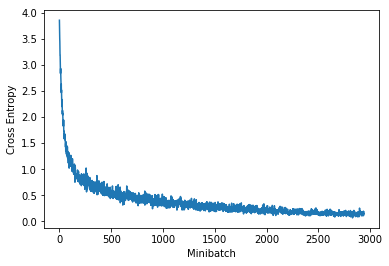

In [14]:
resnet50 = models.resnet50(pretrained=True)

# Freezing the Model
for param in resnet50.parameters():
    param.requires_grad = False
    
# Replace the output layer
resnet50.fc = nn.Sequential(
              nn.Linear(2048, 1000), 
              nn.BatchNorm1d(1000),
              nn.ReLU(), 
              nn.Dropout(0.2),
              nn.Linear(1000, NUM_CLASSES)
)

# Training
torch.manual_seed(RANDOM_SEED)

resnet50 = resnet50.to(DEVICE)
optimizer = torch.optim.SGD(resnet50.parameters(), lr = LEARNING_RATE)

minibatch_cost_resnet50, epoch_cost_resnet50, predictions_resnet50 = train_CNN(resnet50, train_loader_resnet, valid_loader_resnet, test_loader_resnet, pretrained = "Resnet")

plt.plot(range(len(minibatch_cost_resnet50)), minibatch_cost_resnet50)
plt.ylabel('Cross Entropy')
plt.xlabel('Minibatch')
plt.show()

In [0]:
del resnet50

## Inception V3

Epoch: 001/020 | Batch 000/147 | Cost: 5.4238
Epoch: 001/020 | Batch 050/147 | Cost: 3.5813
Epoch: 001/020 | Batch 100/147 | Cost: 2.9531
Time elapsed: 43.49 min
Epoch: 002/020 | Batch 000/147 | Cost: 2.3027
Epoch: 002/020 | Batch 050/147 | Cost: 1.8974
Epoch: 002/020 | Batch 100/147 | Cost: 1.9412
Time elapsed: 50.30 min
Epoch: 003/020 | Batch 000/147 | Cost: 1.6913
Epoch: 003/020 | Batch 050/147 | Cost: 1.5762
Epoch: 003/020 | Batch 100/147 | Cost: 1.8399
Time elapsed: 57.12 min
Epoch: 004/020 | Batch 000/147 | Cost: 1.4377
Epoch: 004/020 | Batch 050/147 | Cost: 1.6309
Epoch: 004/020 | Batch 100/147 | Cost: 1.3991
Time elapsed: 63.92 min
Epoch: 005/020 | Batch 000/147 | Cost: 1.1202
Epoch: 005/020 | Batch 050/147 | Cost: 1.4852
Epoch: 005/020 | Batch 100/147 | Cost: 1.2858
Time elapsed: 70.78 min
Epoch: 006/020 | Batch 000/147 | Cost: 1.4497
Epoch: 006/020 | Batch 050/147 | Cost: 1.2952
Epoch: 006/020 | Batch 100/147 | Cost: 1.3435
Time elapsed: 77.64 min
Epoch: 007/020 | Batch 000/1

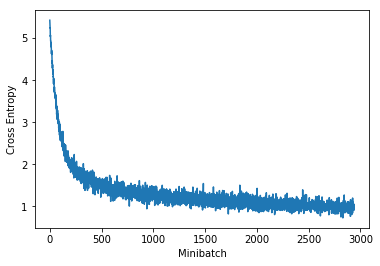

In [0]:
incept3 = models.inception_v3(pretrained=True)

# Freezing the Modle
for param in incept3.parameters():
    param.requires_grad = False
    
# Replace the output layer
num_ftrs1 = incept3.AuxLogits.fc.in_features
incept3.AuxLogits.fc = nn.Linear(num_ftrs1, NUM_CLASSES)

incept3.fc = nn.Sequential(
              nn.Linear(2048, 1000), 
              nn.BatchNorm1d(1000),
              nn.ReLU(), 
              nn.Dropout(0.2),
              nn.Linear(1000, NUM_CLASSES)
)

# Training
torch.manual_seed(RANDOM_SEED)

incept3 = incept3.to(DEVICE)
optimizer = torch.optim.SGD(incept3.parameters(),lr = LEARNING_RATE)

minibatch_cost_incept, epoch_cost_incept, predicted_labels = train_CNN(incept3, train_loader_incept, valid_loader_incept, test_loader_incept, pretrained = "Inception")

plt.plot(range(len(minibatch_cost_incept)), minibatch_cost_incept)
plt.ylabel('Cross Entropy')
plt.xlabel('Minibatch')
plt.show()

In [0]:
del incept3